# Ejercicio día 29-07-22

(series de tiempo)

Primero ejecutar `pip install -r requirements.txt`

In [3]:
# a pesar de ejecutar requirements, se debe ejecutar lo siguiente:
! pip install pandas
! pip install matplotlib
! pip install seaborn
! pip install sklearn
! pip install statsmodels
! pip install lightgbm


  Using cached pandas-1.4.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.7 MB)
  Using cached numpy-1.23.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Using cached pytz-2022.1-py2.py3-none-any.whl (503 kB)

[notice] A new release of pip available: 22.2 -> 22.2.1
[notice] To update, run: pip install --upgrade pip


In [16]:
# librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.metrics import mean_squared_error, mean_absolute_error

from lightgbm import LGBMRegressor

In [17]:
# data
df_raw = pd.read_csv('../data/raw/bike_sharing_train.csv')
df_test = pd.read_csv('../data/raw/bike_sharing_test.csv')

In [18]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [19]:
df_raw.sample(10)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
8218,2012-07-03 19:00:00,3,0,1,2,34.44,37.120,36,8.9981,66,431,497
7488,2012-05-11 09:00:00,2,0,1,1,19.68,23.485,41,19.9995,34,288,322
10362,2012-11-17 04:00:00,4,0,0,1,9.84,11.365,70,12.9980,1,6,7
4532,2011-11-01 22:00:00,4,0,1,1,14.76,18.940,81,0.0000,5,91,96
10653,2012-12-10 07:00:00,4,0,1,2,15.58,19.695,94,16.9979,3,291,294
9661,2012-10-06 22:00:00,4,0,0,1,18.04,21.970,62,8.9981,45,140,185
10757,2012-12-14 15:00:00,4,0,1,1,16.40,20.455,47,11.0014,57,252,309
4719,2011-11-09 17:00:00,4,0,1,1,18.86,22.725,63,7.0015,27,458,485
7540,2012-05-13 13:00:00,2,0,0,1,27.88,31.820,54,16.9979,255,347,602
9174,2012-09-05 15:00:00,3,0,1,1,31.98,38.635,70,12.9980,41,204,245


In [22]:
df_interim = df_raw.copy()

In [23]:
# convierto a fecha
df_interim['datetime']=pd.to_datetime(df_interim['datetime'])
# asigno esa columna al índice
df_interim = df_interim.set_index(df_interim['datetime'])
# creo variable hora
df_interim['hour'] = df_interim.index.hour
# creo variable día
df_interim['day'] = df_interim.index.day
# creo variable mes
df_interim['month'] = df_interim.index.month
# elimino variables que no necesito
df_interim = df_interim.drop(['datetime', 'casual', 'registered'], axis = 1)


In [24]:
df_interim.sample(10)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,day,month
datetime,,,,,,,,,,,,
2012-07-01 20:00:00,3,0,0,1,34.44,37.120,39,8.9981,332,20,1,7
2012-08-16 12:00:00,3,0,1,1,32.80,34.850,33,7.0015,343,12,16,8
2012-04-05 21:00:00,2,0,1,1,17.22,21.210,47,12.9980,234,21,5,4
2011-05-11 14:00:00,2,0,1,1,25.42,31.060,53,6.0032,177,14,11,5
2012-12-13 10:00:00,4,0,1,1,13.12,15.150,45,19.0012,167,10,13,12
2011-03-07 14:00:00,1,0,1,1,13.12,14.395,36,27.9993,77,14,7,3
2012-10-11 10:00:00,4,0,1,1,18.04,21.970,41,23.9994,204,10,11,10
2011-12-19 12:00:00,4,0,1,1,12.30,13.635,61,22.0028,141,12,19,12
2012-09-04 23:00:00,3,0,1,1,29.52,34.850,74,19.9995,95,23,4,9


In [66]:
df = df_interim.copy()

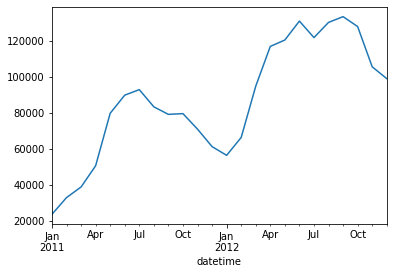

In [67]:
# agregación (suma por mes)
# Y = año, M = mes, W = semana, D = día, etc
df['count'].resample('M').sum().plot()
plt.show()

Hay tendencia de crecimiento

In [28]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
season,10886.0,2.506614,1.116174,1.00,2.0000,3.000,4.0000,4.0000
holiday,10886.0,0.028569,0.166599,0.00,0.0000,0.000,0.0000,1.0000
workingday,10886.0,0.680875,0.466159,0.00,0.0000,1.000,1.0000,1.0000
weather,10886.0,1.418427,0.633839,1.00,1.0000,1.000,2.0000,4.0000
temp,10886.0,20.230860,7.791590,0.82,13.9400,20.500,26.2400,41.0000
atemp,10886.0,23.655084,8.474601,0.76,16.6650,24.240,31.0600,45.4550
humidity,10886.0,61.886460,19.245033,0.00,47.0000,62.000,77.0000,100.0000
windspeed,10886.0,12.799395,8.164537,0.00,7.0015,12.998,16.9979,56.9969
count,10886.0,191.574132,181.144454,1.00,42.0000,145.000,284.0000,977.0000
hour,10886.0,11.541613,6.915838,0.00,6.0000,12.000,18.0000,23.0000


Acá habría que hacer EDA, histogramas, etc

In [29]:
df

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,day,month
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,16,0,1,1
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,40,1,1,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,32,2,1,1
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,13,3,1,1
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,336,19,19,12
2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,241,20,19,12
2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,168,21,19,12


La unidad mínima en que se puede agrupar es la hora

In [38]:
# creo serie con frecuencia diaria y descompongo en tendencia, estacionalidad y residuales
res = seasonal_decompose(df['count'].values, period = 24)
res_observed = res.observed
res_trend = res.trend
res_seasonal = res.seasonal
res_residual = res.resid

In [39]:
len(res_observed)

10886

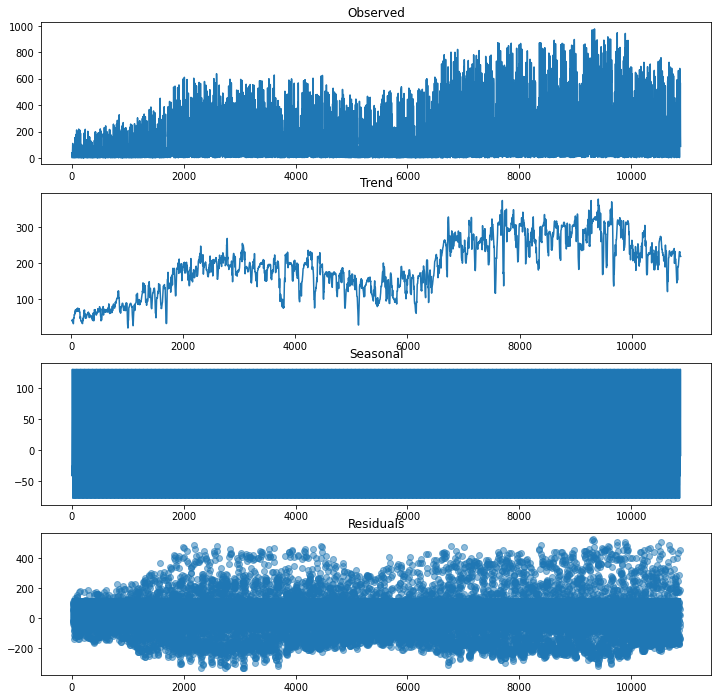

In [32]:
# grafico 
fig, ax = plt.subplots(4, figsize = (12, 12))
ax[0].set_title('Observed')
ax[0].plot(res_observed)
ax[1].set_title('Trend')
ax[1].plot(res_trend)
ax[2].set_title('Seasonal')
ax[2].plot(res_seasonal)
ax[3].set_title('Residuals')
ax[3].plot(res_seasonal)
ax[3].scatter(y = res_residual, x = range(len(res_residual)), alpha = 0.5)
plt.show()

Se ve apretado por la frecuencia (son 10000 datos aprox)

In [46]:
# tomo los últimos 250 datos de la serie
res = seasonal_decompose(df['count'].values[-250:], period = 24)
res_observed = res.observed
res_trend = res.trend
res_seasonal = res.seasonal
res_residual = res.resid

In [47]:
len(res_observed)

250

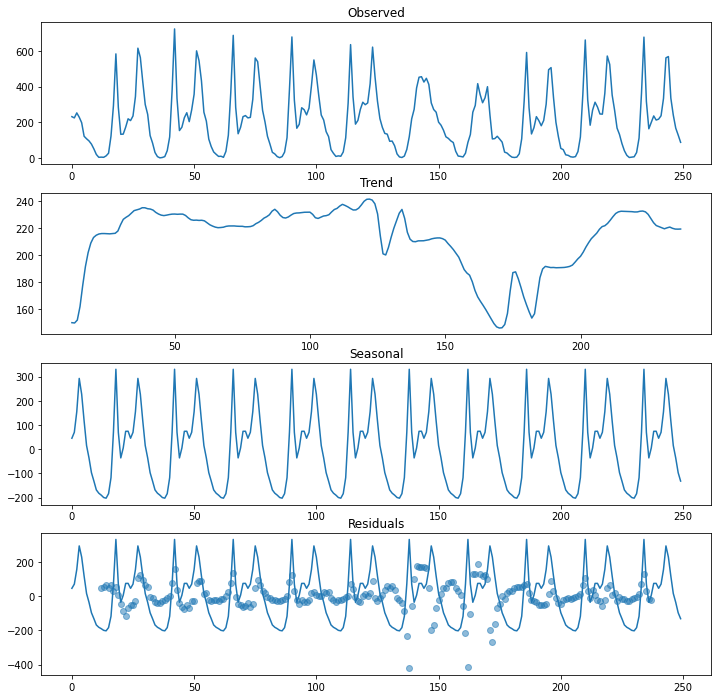

In [48]:
# grafico (cada punto es un día)
fig, ax = plt.subplots(4, figsize = (12, 12))
ax[0].set_title('Observed')
ax[0].plot(res_observed)
ax[1].set_title('Trend')
ax[1].plot(res_trend)
ax[2].set_title('Seasonal')
ax[2].plot(res_seasonal)
ax[3].set_title('Residuals')
ax[3].plot(res_seasonal)
ax[3].scatter(y = res_residual, x = range(len(res_residual)), alpha = 0.5)
plt.show()

Ahora se ve mejor!! Aparentemente hay un patrón semanal

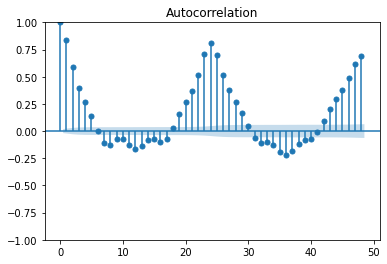

In [36]:
# autocorrelación (2 días), cada punto es una hora
plot_acf(df['count'].values, lags = 48)
plt.show()

Se repite el ciclo cada 24 hs

In [68]:
X = df.drop('count', axis = 1)
y = df['count']
horizon = 168 # cantidad de hs de una semana
# investigar slicing (para saber cómo divide el data frame)
X_train = X.iloc[:-horizon,:] # toma filas desde 0 hasta (len - 168), y todas las columnas
X_train = X.iloc[:-horizon,:] # toma filas desde 0 hasta (len - 168), y todas las columnas
X_test = X.iloc[-horizon:,:] # toma filas desde 168 hasta len, y todas las columnas
y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]

In [51]:
print(len(y_train))
print(len(y_test))
# el 168 queda en test!!

10718
168


In [69]:
model = LGBMRegressor(random_state = 123)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [55]:
mae = np.round(mean_absolute_error(y_test, y_pred), 1)
rmse = np.round(np.sqrt(mean_squared_error(y_test, y_pred)), 1)
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

# me equivocaría en promedio con 53 bicicletas

MAE: 53.8
RMSE: 73.8


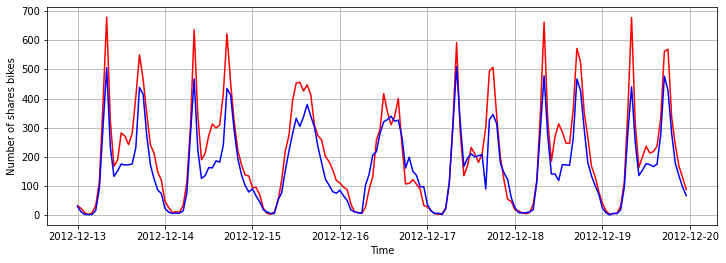

In [57]:
fig = plt.figure(figsize = (12,4))
plt.plot(y_test, color = 'red')
plt.plot(pd.Series(y_pred, index = y_test.index), color = 'blue')
plt.xlabel('Time')
plt.ylabel('Number of shares bikes')
plt.grid()
plt.show()

In [70]:
# importancia de las variables
df_var_imp = pd.DataFrame({'var':model.feature_name_, 'imp': model.feature_importances_}).sort_values(by = 'imp', ascending = False)
df_var_imp

,var,imp
8,hour,752
9,day,401
6,humidity,392
4,temp,323
2,workingday,253
10,month,226
5,atemp,222
7,windspeed,190
0,season,102
3,weather,87


"imp" no es el coeficiente del modelo, es un valor referencial. El día y la hora son variables claves, la humedad y la temperatura también.

Los grtáficos muestran una periodicidad semanal

In [71]:
# rezago de una semana
df['count_lag_week'] = df['count'].shift(24*7)
df = df.dropna(how = 'any', axis = 0) # para eliminar la primera fila que no tiene contr qué rezagar 

MAE:32.7, RMSE:48.4


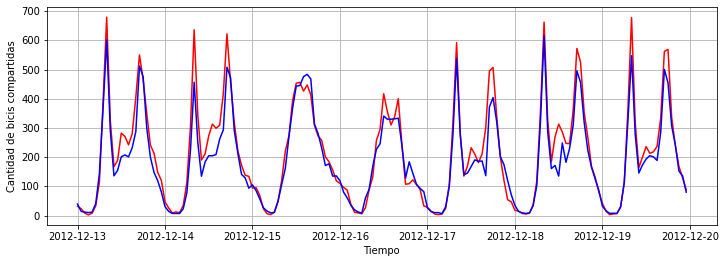

In [72]:
# vuelvo a correr el modelo

X = df.drop('count',axis=1)
y = df['count']

horizon = 168

X_train, X_test = X.iloc[:-horizon,:], X.iloc[-horizon:,:]

y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]

model = LGBMRegressor(random_state = 123)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = np.round(mean_absolute_error(y_test, y_pred),1)
rmse = np.round(np.sqrt(mean_squared_error(y_test, y_pred)),1)
print(f'MAE:{mae}, RMSE:{rmse}')
fig = plt.figure(figsize = (12,4))
plt.plot(y_test, color='Red')
plt.plot(pd.Series(y_pred, index = y_test.index), color = 'Blue')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de bicis compartidas')
plt.grid()
plt.show()

La predicción mejora al considerar los rezagos semanales

In [73]:
# importancia de las variables
df_var_imp = pd.DataFrame({'var':model.feature_name_, 'imp': model.feature_importances_}).sort_values(by = 'imp', ascending = False)
df_var_imp

,var,imp
8,hour,703
11,count_lag_week,506
9,day,347
6,humidity,309
4,temp,296
2,workingday,237
5,atemp,170
10,month,154
7,windspeed,120
3,weather,70


Se podría probar con un rezago de un día, pero se puede estar comparando un lunes con un domingo.

Se podría probar un rezago de un mes para ver el tema de la estacionalidad.

Si la serie fuera más larga se podría probar rezagos de un año, pero en este caso hay solamente dos años

In [74]:
# rezago de un mes
df['count_lag_month'] = df['count'].shift(24*30)
df = df.dropna(how = 'any', axis = 0) # para eliminar la primera fila que no tiene contr qué rezagar 

MAE:35.5, RMSE:54.7


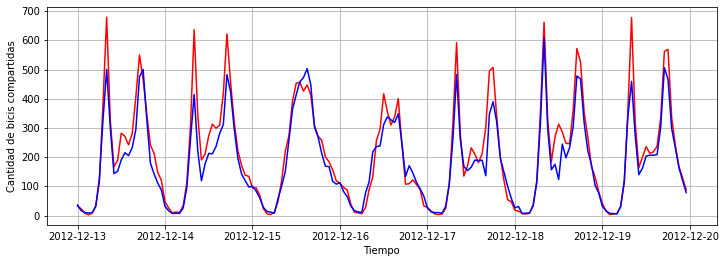

In [75]:
# vuelvo a correr el modelo

X = df.drop('count',axis=1)
y = df['count']

horizon = 168

X_train, X_test = X.iloc[:-horizon,:], X.iloc[-horizon:,:]

y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]

model = LGBMRegressor(random_state = 123)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = np.round(mean_absolute_error(y_test, y_pred),1)
rmse = np.round(np.sqrt(mean_squared_error(y_test, y_pred)),1)
print(f'MAE:{mae}, RMSE:{rmse}')
fig = plt.figure(figsize = (12,4))
plt.plot(y_test, color='Red')
plt.plot(pd.Series(y_pred, index = y_test.index), color = 'Blue')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de bicis compartidas')
plt.grid()
plt.show()

In [76]:
# importancia de las variables
df_var_imp = pd.DataFrame({'var':model.feature_name_, 'imp': model.feature_importances_}).sort_values(by = 'imp', ascending = False)
df_var_imp

,var,imp
8,hour,655
11,count_lag_week,477
9,day,300
12,count_lag_month,295
6,humidity,251
2,workingday,239
4,temp,218
10,month,156
5,atemp,154
7,windspeed,112


No funciona tan bien con rezago mensual!!

Este modelo utiliza Gradient Boosting, se puede probar con Random Forest